<a href="https://colab.research.google.com/github/hisaylama/Graph-Convolution-Neural-Newtwork/blob/main/Glass_Transition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")

    #added snippet
    subprocess.check_call([
    os.path.join(conda_path, "bin", "conda"),
    "install",
    "--yes",
    "-c", "conda-forge",  # Use conda-forge channel
    "python=={}".format(python_version),
    "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])

    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
INFO:__main__:add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
python version: 3.10.12
INFO:__main__:python version: 3.10.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:__main__:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:__main__:done
installing miniconda to /root/miniconda
INFO:__main__:installing miniconda to /root/miniconda
done
INFO:__main__:done
installing rdkit
INFO:__main__:installing rdkit
done
INFO:__main__:done
rdkit-2023.09.5 installation finished!
INFO:__main__:rdkit-2023.09.5 installation finished!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder

#import the molecules.csv
df=pd.read_csv("molecules.csv", encoding = "latin1") #added encoding = "latin1"
df=df.dropna(how="all")
df=df.iloc[:,:3]
df["Nomenclature Name"]=df.iloc[:,2]
df["Molecular Structure"]=df.iloc[:,1]
df["Tg"]=df.iloc[:,0]
df=df[["Nomenclature Name","Molecular Structure","Tg"]]
df.head(10)

#The details for the file: it contains the name of a chemical, molecular structure and Tg

,Nomenclature Name,Molecular Structure,Tg
0,Poly(4-biphenyl acrylate),C=CC(=O)Oc2ccc(c1ccccc1)cc2,383.0
1,Poly(butyl acrylate),CCCCOC(=O)C=C,219.0
2,Poly(sec-butyl acrylate),CC(OC(=O)C=C)CC,250.0
3,Poly(2-tertbutylphenyl acrylate),C=CC(=O)Oc1ccccc1C(C)(C)C,345.0
4,Poly(4-tertbutylphenyl acrylate),C=CC(=O)Oc1ccc(C(C)(C)C)cc1,344.0
7,Poly(4-cyanobenzyl acrylate),C=CC(=O)Oc1ccc(C#N)cc1,317.0
8,Poly(2-cyanoisobutyl acrylate),C=CC(=O)OCC(C)C#N,324.0
9,Poly(2-cyanoethyl acrylate),C=CC(=O)OCCC#N,277.0
10,Poly(2-cyanohexyl acrylate),C=CC(=O)OCCCCCCC#N,358.0
11,Poly(2-cyanoisopropyl acrylate),C=CC(=O)OC(C)C#N,339.0


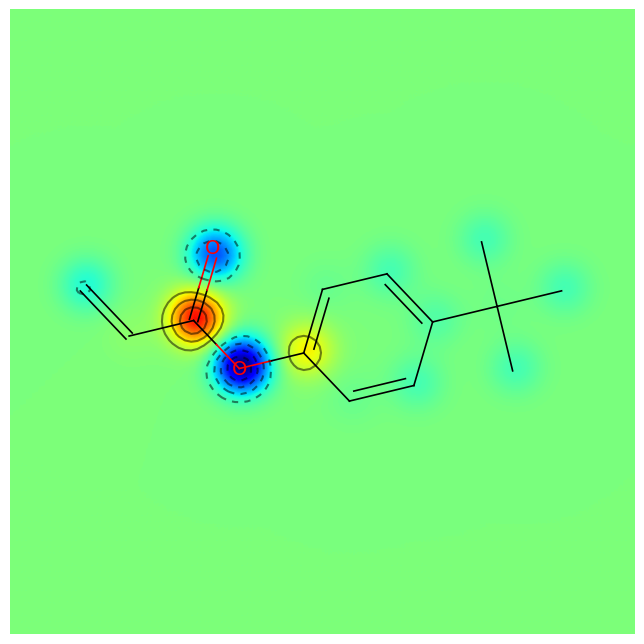

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
#creating object with SMILES (Simplified Molecular Input Line Entry System) notation
mol = Chem.MolFromSmiles('C=CC(=O)Oc1ccc(C(C)(C)C)cc1')
#
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]

#Geenrating the similarity map
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
AllChem.ComputeGasteigerCharges(mol)

In [ ]:
#Converting the data into a binary matrix (one-hot encoding)
def encoding(df):
  encoded=[]
  elements=[['c'], ['n'], ['o'], ['C'], ['N'], ['F'], ['='], ['O'],
            ['('], [')'], ['1'],['2'],['#'],['Cl'],['/']]
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(elements)
  enc.categories_

  df1=df["Molecular Structure"].apply(lambda x: pd.Series(list(x)))
  for i in range(df1.shape[0]):
    x=enc.transform(pd.DataFrame(df1.iloc[i,:]).dropna(how="all").values).toarray()
    y=np.zeros(((df1.shape[1]-x.shape[0]),len(elements)))
    encoded.append(np.vstack((x,y)))
  return encoded

def encoded_generate_images(df):
  listt=encoding(df)
  plt.figure(figsize=(20,100))
  for i in range(len(listt)):
    plt.subplot(len(listt),5,i+1)
    plt.imshow(listt[i])

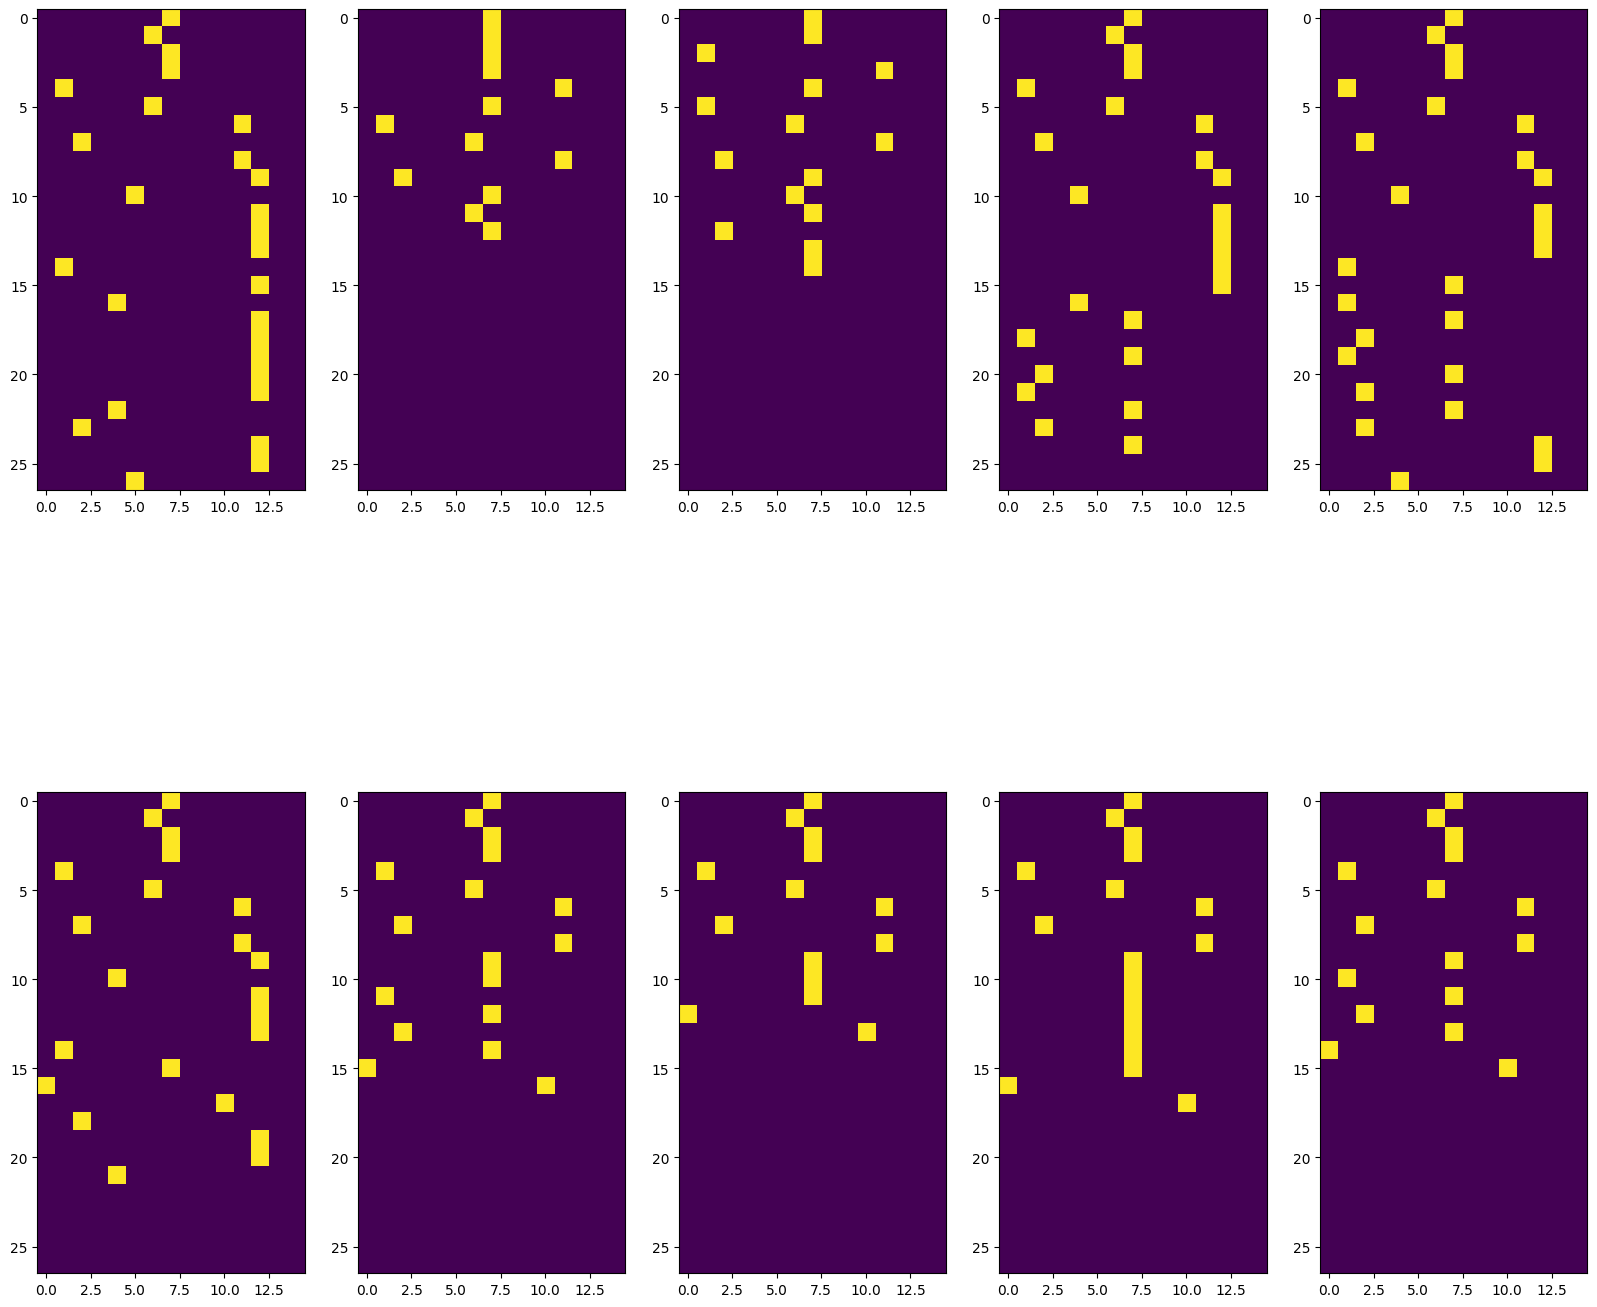

In [ ]:
encoded_generate_images(df.head(10))

In [ ]:
#Encoding the smile datasets into proper input format
X=encoding(df)
X=np.array(X)

In [ ]:
Y=df["Tg"].values
Y.shape

(351,)

In [ ]:
#Include all import ML models
import keras
from keras.models import Sequential
from keras.layers import Dense,MaxPool2D,Conv2D,Conv1D,Flatten,MaxPooling1D
from keras import optimizers
from keras.layers import Dropout

#Write the machine learning model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Assuming X and Y are your input and output data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=8, activation='relu', kernel_regularizer="l2", input_shape=(65, 15)))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.005)  # Use Adam optimizer from keras.optimizers
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Ensure that your input data has the correct shape, e.g., (65, 15)
Model = model.fit(x=X_train, y=y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
16/16 [==============================] - 1s 20ms/step - loss: 253.7334 - val_loss: 139.7227
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 92.7300 - val_loss: 74.0252
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 56.2937 - val_loss: 49.1256
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 42.7681 - val_loss: 42.0231
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 37.1529 - val_loss: 50.5204
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 36.0099 - val_loss: 44.4164
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 31.2278 - val_loss: 35.6716
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 30.5257 - val_loss: 34.6827
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 29.1689 - val_loss: 37.7475
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 26.4783 - val_lo

In [ ]:
#How to test the model?

#---

In [ ]:
#Summary of CNN model that was used for optimizing
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 58, 128)           15488     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 11, 128)           0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 11, 128)           0         
                                                                 
 flatten_5 (Flatten)         (None, 1408)              0         
                                                                 
 dense_16 (Dense)            (None, 50)                70450     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                      

In [ ]:
#Predicting from the test dataset using the ML model
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)

MAE_test=abs(y_predtest.reshape(y_test.shape)-y_test).sum()/y_test.shape
MAE_train=abs(y_predtrain.reshape(y_train.shape)-y_train).sum()/y_train.shape
print("Mean Absolute Error on Training Set = ",MAE_train.item())
print("Mean Absolute Error on Test Set = ",MAE_test.item())

2/2 [==============================] - 0s 6ms/step
Mean Absolute Error on Training Set =  13.478149850027902
Mean Absolute Error on Test Set =  24.32212236192491


Text(0.5, 0, 'y_predicted')

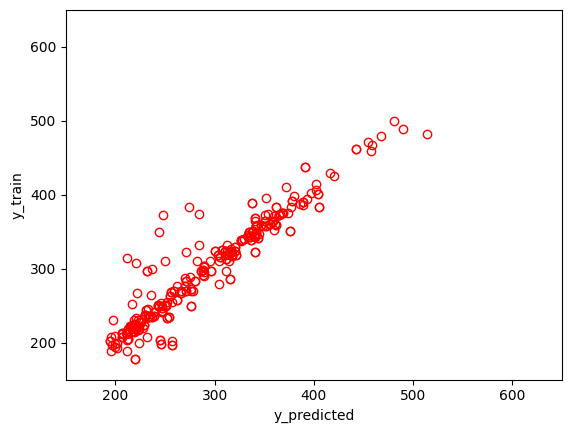

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_predtrain, y_train, 'o', markeredgecolor='red', markerfacecolor='none')
plt.xlim([150,650])
plt.ylim([150,650])
#y_train.shape
#y_test.shape
plt.ylabel("y_train")
plt.xlabel("y_predicted")

In [ ]:
y_predtrain.reshape(315)
y_train.reshape(315)

import plotly.express as px
fig = px.scatter(x=y_predtrain.reshape(315), y=y_train.reshape(315))
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_predtrain.reshape(315), y=y_train.reshape(315),
    name='sin',
    mode='markers',
    marker_color='rgba(100, 1, 0, .8)'))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig.update_layout(title='Styled Scatter',
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtrain.reshape(315),
    y = y_train.reshape(315),
    mode='markers',
    marker=dict(
        color=np.random.randn(315),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()

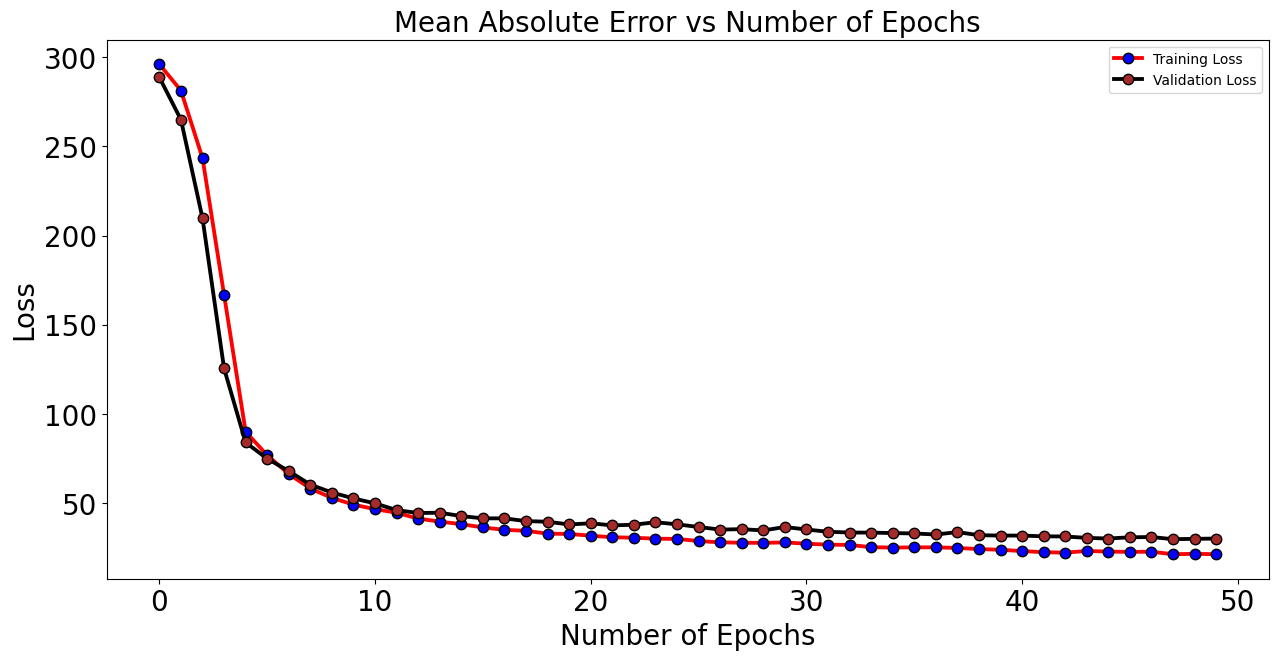

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(Model.history["loss"],color='r', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='b',
         markeredgecolor='black',
         markeredgewidth=1,label="Training Loss")

plt.plot(Model.history['val_loss'],color='black', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='brown',
         markeredgecolor='black',
         markeredgewidth=1,label="Validation Loss")

plt.xlabel("Number of Epochs",size=20,color="black")
plt.ylabel("Loss",size=20,color="black")
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Mean Absolute Error vs Number of Epochs",size=20)
plt.legend()
plt.show()

## Neural network using bond feautres

In [ ]:
mw = {"C": 12, "c": 12, "O": 16, "o": 16, "N": 14, "F": 19}

def Molecular_Weight(text):
    Mass = [mw.get(element, 0) for element in text]
    return sum(Mass)




```
# This is formatted as code

def Molecular_Weight(text):
  Mass=[]
  for elements in text:
    if elements=="C":
      Mass.append(mw[elements])
    elif elements=="c":
      Mass.append(mw[elements])
    elif elements=="o":
      Mass.append(mw[elements])
    elif elements=="O":
      Mass.append(mw[elements])
    elif elements=="F":
      Mass.append(mw[elements])
    elif elements=="N":
      Mass.append(mw[elements])  
  return sum(Mass)
```



In [ ]:
#Adding new column to the dataset df, C_Atoms_Ring, C_Atoms_Chain, O_Atoms_Chain, O_Atoms_Ring, N_Double Bonds_Ring
#N_Double Bonds_Chain, Nitrogen_Atoms, F_Atoms, F_Atoms, MW, Total Number of Atoms, Number of Single Bonds
df["C_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c'))
df["C_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('C'))
df["O_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('O'))
df["O_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('o'))
df["N_Double Bonds_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c')/2)
df["N_Double Bonds_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('='))
df["Nitrogen_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('N'))
df["F_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('F'))
df["MW"]=df["Molecular Structure"].apply(lambda x: Molecular_Weight(x))
df["Total Number of Atoms"]=df["Molecular Structure"].apply(lambda x: len(x))
df["Number of Single Bonds"]=df["Molecular Structure"].apply(lambda x:len(x)-x.count('=')-1)

In [ ]:
df.head()

,Nomenclature Name,Molecular Structure,Tg,C_Atoms_Ring,C_Atoms_Chain,O_Atoms_Chain,O_Atoms_Ring,N_Double Bonds_Ring,N_Double Bonds_Chain,Nitrogen_Atoms,F_Atoms,MW,Total Number of Atoms,Number of Single Bonds
0,Poly(4-biphenyl acrylate),C=CC(=O)Oc2ccc(c1ccccc1)cc2,383.0,12,3,2,0,6.0,2,0,0,212,27,24
1,Poly(butyl acrylate),CCCCOC(=O)C=C,219.0,0,7,2,0,0.0,2,0,0,116,13,10
2,Poly(sec-butyl acrylate),CC(OC(=O)C=C)CC,250.0,0,7,2,0,0.0,2,0,0,116,15,12
3,Poly(2-tertbutylphenyl acrylate),C=CC(=O)Oc1ccccc1C(C)(C)C,345.0,6,7,2,0,3.0,2,0,0,188,25,22
4,Poly(4-tertbutylphenyl acrylate),C=CC(=O)Oc1ccc(C(C)(C)C)cc1,344.0,6,7,2,0,3.0,2,0,0,188,27,24


In [ ]:
X=df.loc[:,"MW":] # input molecular weight, total number of atoms, and number of single bond
Y=df[["Tg"]] # predicted output "Tg"
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X.shape

(351, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=3, activation="relu",kernel_regularizer="l2"))
#model.add(Dense(20,activation="relu",kernel_regularizer="l2"))
model.add(Dense(10,activation="relu",kernel_regularizer="l2"))
#model.add(Dense(12, activation="relu",kernel_regularizer="l2"))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                160       
                                                                 
 dense_19 (Dense)            (None, 10)                410       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 581 (2.27 KB)
Trainable params: 581 (2.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = Adam(learning_rate=0.09)  # Use Adam directly
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Ensure that your input data has the correct shape, e.g., (58, 15)
Model = model.fit(x=X_train, y=y_train, epochs=70, batch_size=64, validation_split=0.1)
#This code should work without any issues. Please make sure you have the

Epoch 1/70
4/4 [==============================] - 1s 58ms/step - loss: 295.6692 - val_loss: 289.1610
Epoch 2/70
4/4 [==============================] - 0s 14ms/step - loss: 267.2982 - val_loss: 226.4554
Epoch 3/70
4/4 [==============================] - 0s 12ms/step - loss: 179.5997 - val_loss: 138.4870
Epoch 4/70
4/4 [==============================] - 0s 12ms/step - loss: 157.1831 - val_loss: 133.1941
Epoch 5/70
4/4 [==============================] - 0s 12ms/step - loss: 117.6512 - val_loss: 106.3601
Epoch 6/70
4/4 [==============================] - 0s 12ms/step - loss: 87.8949 - val_loss: 95.2048
Epoch 7/70
4/4 [==============================] - 0s 12ms/step - loss: 69.2440 - val_loss: 66.3946
Epoch 8/70
4/4 [==============================] - 0s 16ms/step - loss: 65.7948 - val_loss: 56.4902
Epoch 9/70
4/4 [==============================] - 0s 23ms/step - loss: 61.7468 - val_loss: 63.0116
Epoch 10/70
4/4 [==============================] - 0s 19ms/step - loss: 59.9704 - val_loss: 58.5142

In [ ]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
print("Train Error = ",abs(y_predtrain.reshape(280)-y_train.values.reshape(280)).sum()/280)
print("Unseen Test Error = ",abs(y_predtest.reshape(71)-y_test.values.reshape(71)).sum()/71)

#CHECK the incosistency with the data


3/3 [==============================] - 0s 4ms/step
Train Error =  45.77011326381138
Unseen Test Error =  54.42317049268266


In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtrain.reshape(280),
    y = y_train.values.reshape(280),
    mode='markers',
    marker=dict(
        color=np.random.randn(71),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtest.reshape(71),
    y = y_test.values.reshape(71),
    mode='markers',
    marker=dict(
        color=np.random.randn(280),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder

# Import the molecules from Excel file
file_path = "MasterSMILES-SFT-logc.csv"  # Update with the correct file path
#df = pd.read_excel(file_path)  # Use read_excel to load Excel files
df = pd.read_csv(file_path)  # Use read_excel to load Excel files
# Uncomment and modify the following lines if needed
df = df.dropna(how="all")
df = df.iloc[:, :3]
df["SMILES"] = df.iloc[:, 0]
df["Name"] = df.iloc[:, 1]
#df["Tg"] = df.iloc[:, 0]
# df = df[["Nomenclature Name", "Molecular Structure", "Tg"]]
df = df[["SMILES", "Name"]]
# Display the first 10 rows of the DataFrame
print(df.head(10))

#The details for the file: it contains the name of a chemical, molecular structure and Tg

         SMILES            Name
0          CCCO      n-propanol
1         CCCCO       n-butanol
2        CCCCCO      n-pentanol
3       CCCCCCO       n-hexanol
4      CCCCCCCO      n-heptanol
5     CCCCCCCCO       n-octanol
6   CC(O)CCCCCC       2-octanol
7   CCC(O)CCCCC       3-octanol
8   CCCC(O)CCCC       4-octanol
9  CCCCCCC(O)CO  1,2-octanediol


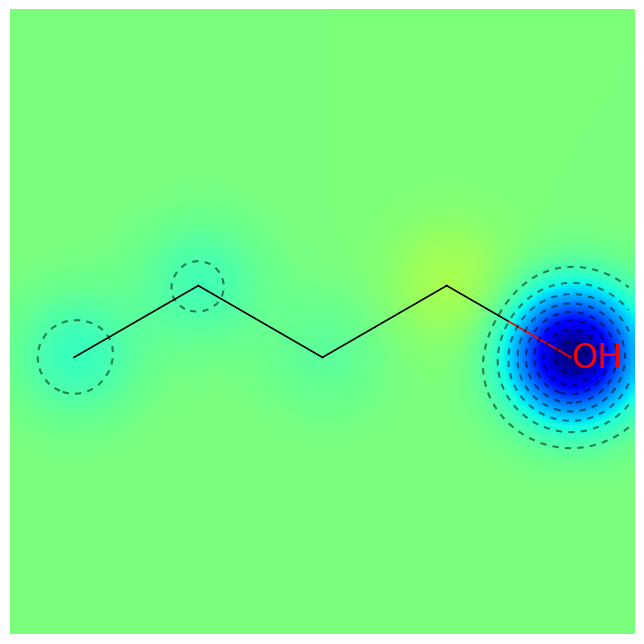

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
#creating object with SMILES (Simplified Molecular Input Line Entry System) notation
mol = Chem.MolFromSmiles('CCCCO')
#
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]

#Geenrating the similarity map
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
AllChem.ComputeGasteigerCharges(mol)